In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
from corner import corner
import pandas as pd
import pymc3 as pm
import seaborn as sns

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

This is the publication style:

In [3]:
w = 433.62/72.0 # Column width in inches
pub_rc = {
    'figure.figsize': (w/2,w/2),
    'text.usetex': True
}

I'm counting anything in [this table](https://www.lsc-group.phys.uwm.edu/ligovirgo/cbcnote/O2/Catalog/) that is a GW:

In [119]:
months2017 = [1, 2, 3, 4, 6, 7, 8]
counts2017 = [1, 0, 0, 0, 1, 1, 5]

months2015 = [9, 10, 12]
counts2015 = [1, 1, 1]

months = concatenate((months2015, months2017))
counts = concatenate((counts2015, counts2017))

rate = sum(counts)/len(months)

rate

1.1

First, a simple calculation: the mean rate of detections is $1$ per month.  At this rate, the probability of five or more detections in a single month is:

In [120]:
def P_more_detections(rate, N):
    assert N >= 1, 'P(N>=0) == 1!'
    ps = [exp(-rate)]
    for i in range(1, N):
        ps.append(ps[-1]*rate/i)
    
    return 1.0 - sum(ps)

P5 = P_more_detections(rate, 5)

print('P(five or more in one month) = {:.4g}'.format(P5))

P(five or more in one month) = 0.005435


But we had seven months, so the probability of five or more in *at least one* of them is 

In [121]:
1 - (1-P_more_detections(rate, 5))**len(months)

0.053042612451975724

Thus, seeing five events in August is not really that surprising (and note that our analysis ignores the steadily-improving sensitivity, Virgo joining in August, etc---those these are at the $\sim 10\%$ level in the sensitivity, so probably not that important).  But it is worth digging a bit deeper (maybe there are two-month periods that are outliers?  or what about triples, etc); and to do so, we must handle the trials factor problem.

## More Sophisticated Modelling

A few words about the model: we treat each month as if it had an independent rate, $\Lambda_i$, with
$$
n_i \sim \mathrm{Poisson}\left( \Lambda_i \right),
$$
but then tie those rates together with a log-normal "population" model:
$$
\log \Lambda_i \sim N\left( \mu, \sigma \right).
$$

So $\mu$ represents the mean of the log of the monthly rate, and $\sigma$ the scatter in the log of the rate from month to month.  In the limit of infinite data with a truly constant rate, $\sigma \to 0$ as $1/\sqrt{N_\mathrm{months}}$ (i.e. our "resolving power" on the month-to-month scatter goes as $1/\sqrt{N_\mathrm{months}}$).  We impose broad priors on $\mu$ and $\sigma$ ($N(0,2)$ for both).  Note, in particular, that the prior on $\sigma$ is flat as $\sigma \to 0$, so we are letting the data tell us whether we have any evidence for non-zero $\sigma$.

In [147]:
normal_population = True

m = pm.Model()
with m:
    mu = pm.Normal('mu', mu=0, sd=10)
    sigma = pm.HalfNormal('sigma', sd=10)
    
    if normal_population:
        lambdas = pm.Bound(pm.Normal, lower=0, upper=None)('lambdas', mu=mu, sd=sigma, shape=(len(counts),))
    else:
        # Log-normal population
        # This trick means that the Lambdas ~ LogNormal(mu, sigma), but the sampler always sees unit-scale Gaussians.
        # We can't employ a similar trick if the population is normal because we cannot ensure positivity
        log_lambda_unit = pm.Normal('log_lambda_unit', mu=0, sd=1, shape=(len(counts),))
        lambdas = pm.Deterministic('lambdas', pm.math.exp(mu + sigma*log_lambda_unit))
    
    data = pm.Poisson('data', lambdas, observed=counts)

In [148]:
with m:
    t = pm.sample(1000, tune=3000, nuts_kwargs={'target_accept': 0.95}, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambdas, sigma, mu]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:28<00:00, 564.67draws/s]
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9001529070318465, but should be close to 0.95. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8615163882580106, but should be close to 0.95. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


/Users/wfarr/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/wfarr/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/wfarr/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c422f1780>,
      dtype=object)

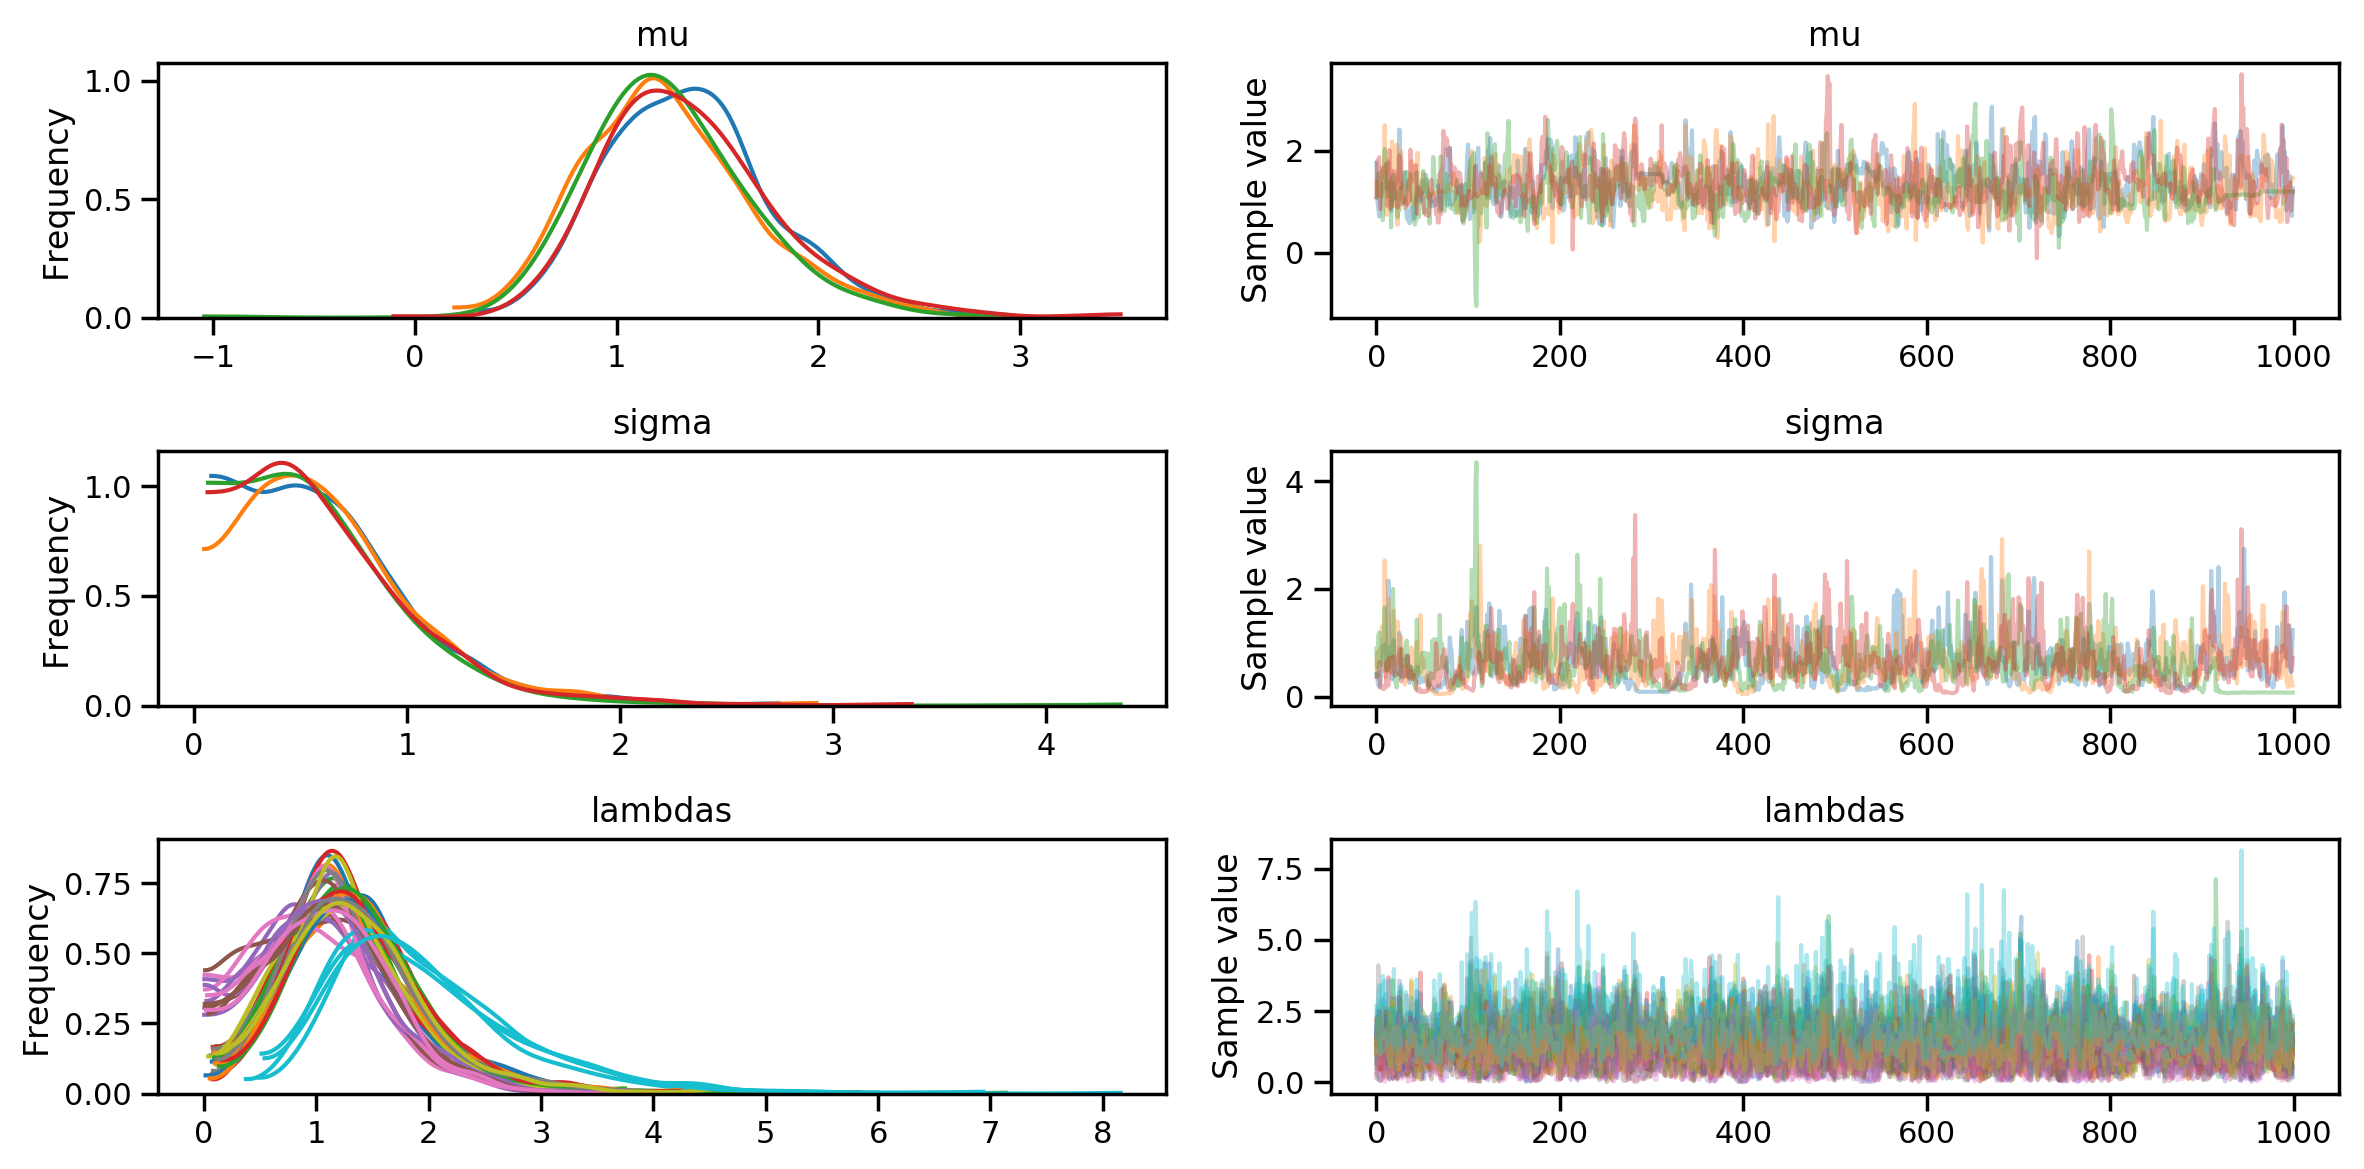

In [149]:
pm.traceplot(t)

Let's look at the lambdas we get out of the fit:

/Users/wfarr/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


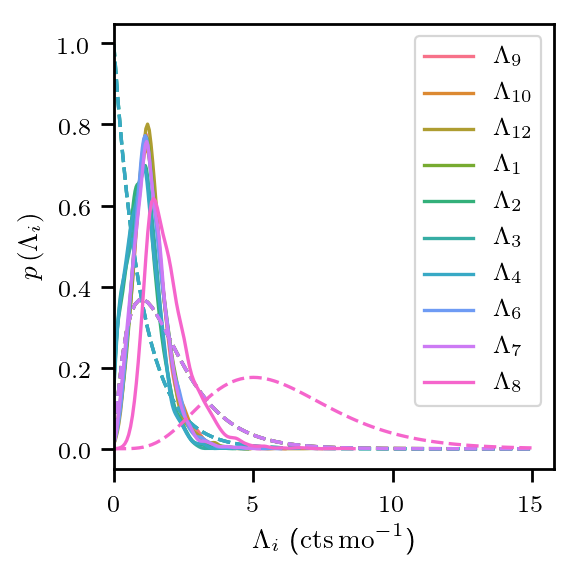

In [150]:
def Poisson_pdf(n):
    Ls = linspace(0, 15, 100)
    ps = Ls**n*exp(-Ls)
    ps = ps / trapz(ps, Ls)
    return Ls, ps

sns.set_context('paper')
mpl.rcParams.update(pub_rc)
try:
    cs = sns.color_palette('husl', len(months))
    for i in range(len(months)):
        sns.kdeplot(t['lambdas'][:,i], label=r'$\Lambda_{{{:d}}}$'.format(months[i]), color=cs[i])
        
        n = counts[i]
        ls, ps = Poisson_pdf(n)
        
        plot(ls, ps, color=cs[i], ls='--')
    legend(loc='best')
    xlabel(r'$\Lambda_i$ ($\mathrm{cts} \, \mathrm{mo}^{-1}$)')
    ylabel(r'$p\left( \Lambda_i \right)$')
    axis(xmin=0)
    tight_layout()
    savefig('note/rates-posterior.pdf')
finally:
    mpl.rcdefaults()
    sns.set_context('notebook')

The two interesting parameters are $\mu$ and $\sigma$.  You can see that the distribution for $\sigma$ extends all the way down to $\sigma = 0$ without any 

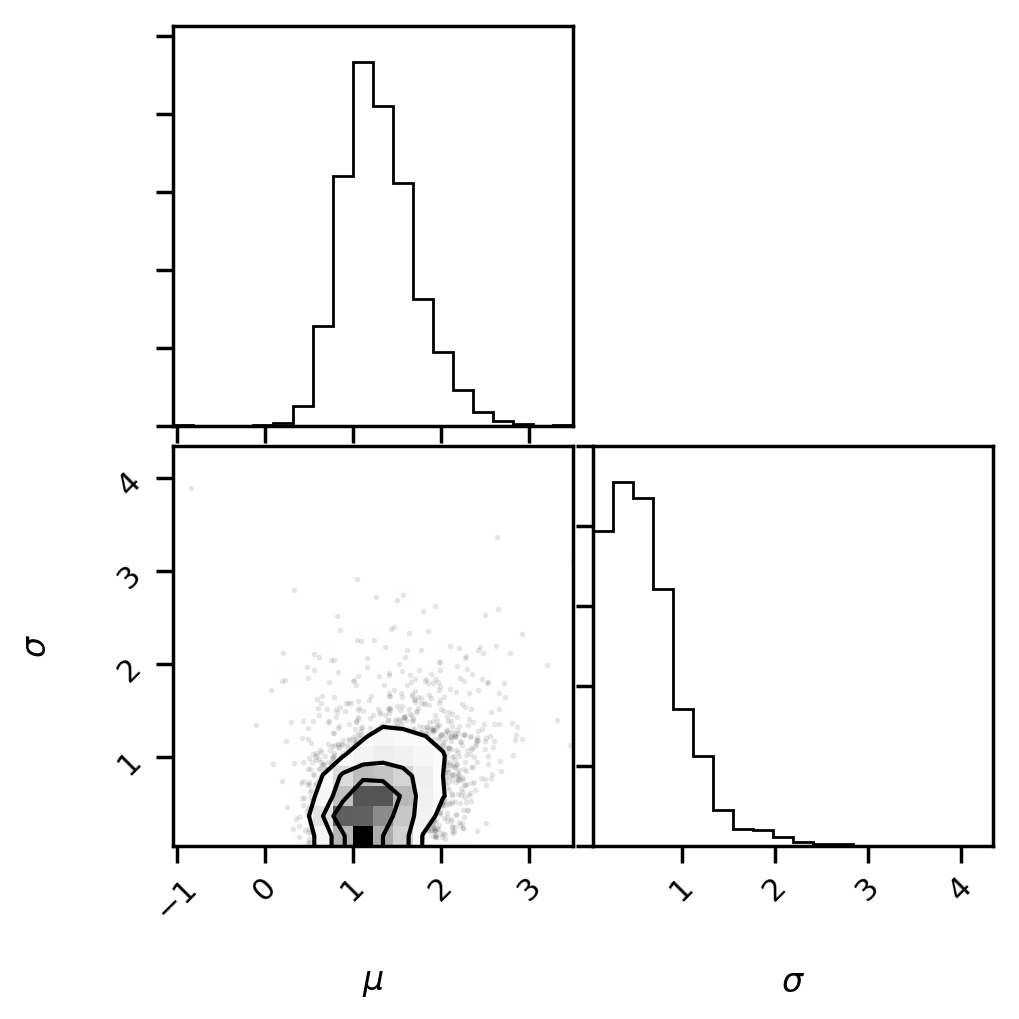

In [151]:
x = corner(column_stack([t[n] for n in ['mu', 'sigma']]), labels=[r'$\mu$', r'$\sigma$'])

In [22]:
def hpd_interval(xs, p):
    xs = sort(array(xs))
    n = xs.shape[0]
    np = int(round(p*n))
    
    uppers = xs[np-1:]
    lowers = xs[:n-np+1]
    intervals = uppers - lowers
    
    imin = argmin(intervals)
    
    return lowers[imin], uppers[imin]    
    
def interval_string(d, prefix='', postfix='', f=0.68):
    s = d
    m = median(s)
    l, h = hpd_interval(s, f)
    
    dl = m-l
    dh = h-m
    
    il = 10**(int(np.ceil(log10(dl))) - 2)
    ih = 10**(int(np.ceil(log10(dl))) - 2)
    
    i = min(il, ih)
    
    m = i*int(round(m/i))
    dl = i*int(round(dl/i))
    dh = i*int(round(dh/i))
    
    return prefix + '{:g}^{{+{:g}}}_{{-{:g}}}'.format(m, dh, dl) + postfix

/Users/wfarr/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


0.54^{+0.2}_{-0.47}


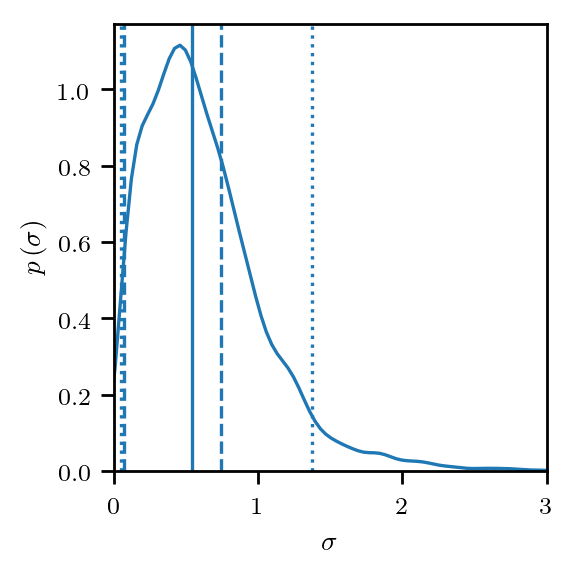

In [153]:
sns.set_context('paper')
mpl.rcParams.update(pub_rc)
try:
    sns.kdeplot(t['sigma'])
    axis(xmin=0)
    l, h = hpd_interval(t['sigma'], 0.68)
    ll, hh = hpd_interval(t['sigma'], 0.95)
    m = quantile(t['sigma'], 0.5)

    axvline(m, color=sns.color_palette()[0])
    axvline(l, color=sns.color_palette()[0], ls='--')
    axvline(h, color=sns.color_palette()[0], ls='--')
    axvline(ll, color=sns.color_palette()[0], ls=':')
    axvline(hh, color=sns.color_palette()[0], ls=':')

    xlabel(r'$\sigma$')
    ylabel(r'$p\left(\sigma\right)$')
    
    axis(xmax=3)
    
    tight_layout()
    savefig('note/sigma.pdf')
finally:
    mpl.rcdefaults()
    sns.set_context('notebook')
    
print(interval_string(t['sigma']))

So, we see that $\sigma = 0$ (all months have the same intrinsic rate of mergers) is consistent with the data at the 2-sigma level---so August was a bit surprising, but not so wildly surprising that we should be concerned.

## Two-Week Chunks

Ben F. gave me counts in two-week chunks, so let's try the analysis with that.

In [5]:
counts_2wk = loadtxt('nevents_per_2week_chunk.txt')

In [14]:
normal_population = False

m = pm.Model()
with m:
    mu = pm.Normal('mu', mu=0, sd=10)
    sigma = pm.HalfNormal('sigma', sd=10)
    
    if normal_population:
        lambdas = pm.Bound(pm.Normal, lower=0, upper=None)('lambdas', mu=mu, sd=sigma, shape=(len(counts_2wk),))
    else:
        # Log-normal population
        # This trick means that the Lambdas ~ LogNormal(mu, sigma), but the sampler always sees unit-scale Gaussians.
        # We can't employ a similar trick if the population is normal because we cannot ensure positivity
        log_lambda_unit = pm.Normal('log_lambda_unit', mu=0, sd=1, shape=(len(counts_2wk),))
        lambdas = pm.Deterministic('lambdas', pm.math.exp(mu + sigma*log_lambda_unit))
    
    data = pm.Poisson('data', lambdas, observed=counts_2wk)

In [17]:
with m:
    trace = pm.sample(1000, tune=2000, chains=4, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_lambda_unit, sigma, mu]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:38<00:00, 137.16draws/s]
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9083325803666582, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c25fbbcc0>,
      dtype=object)

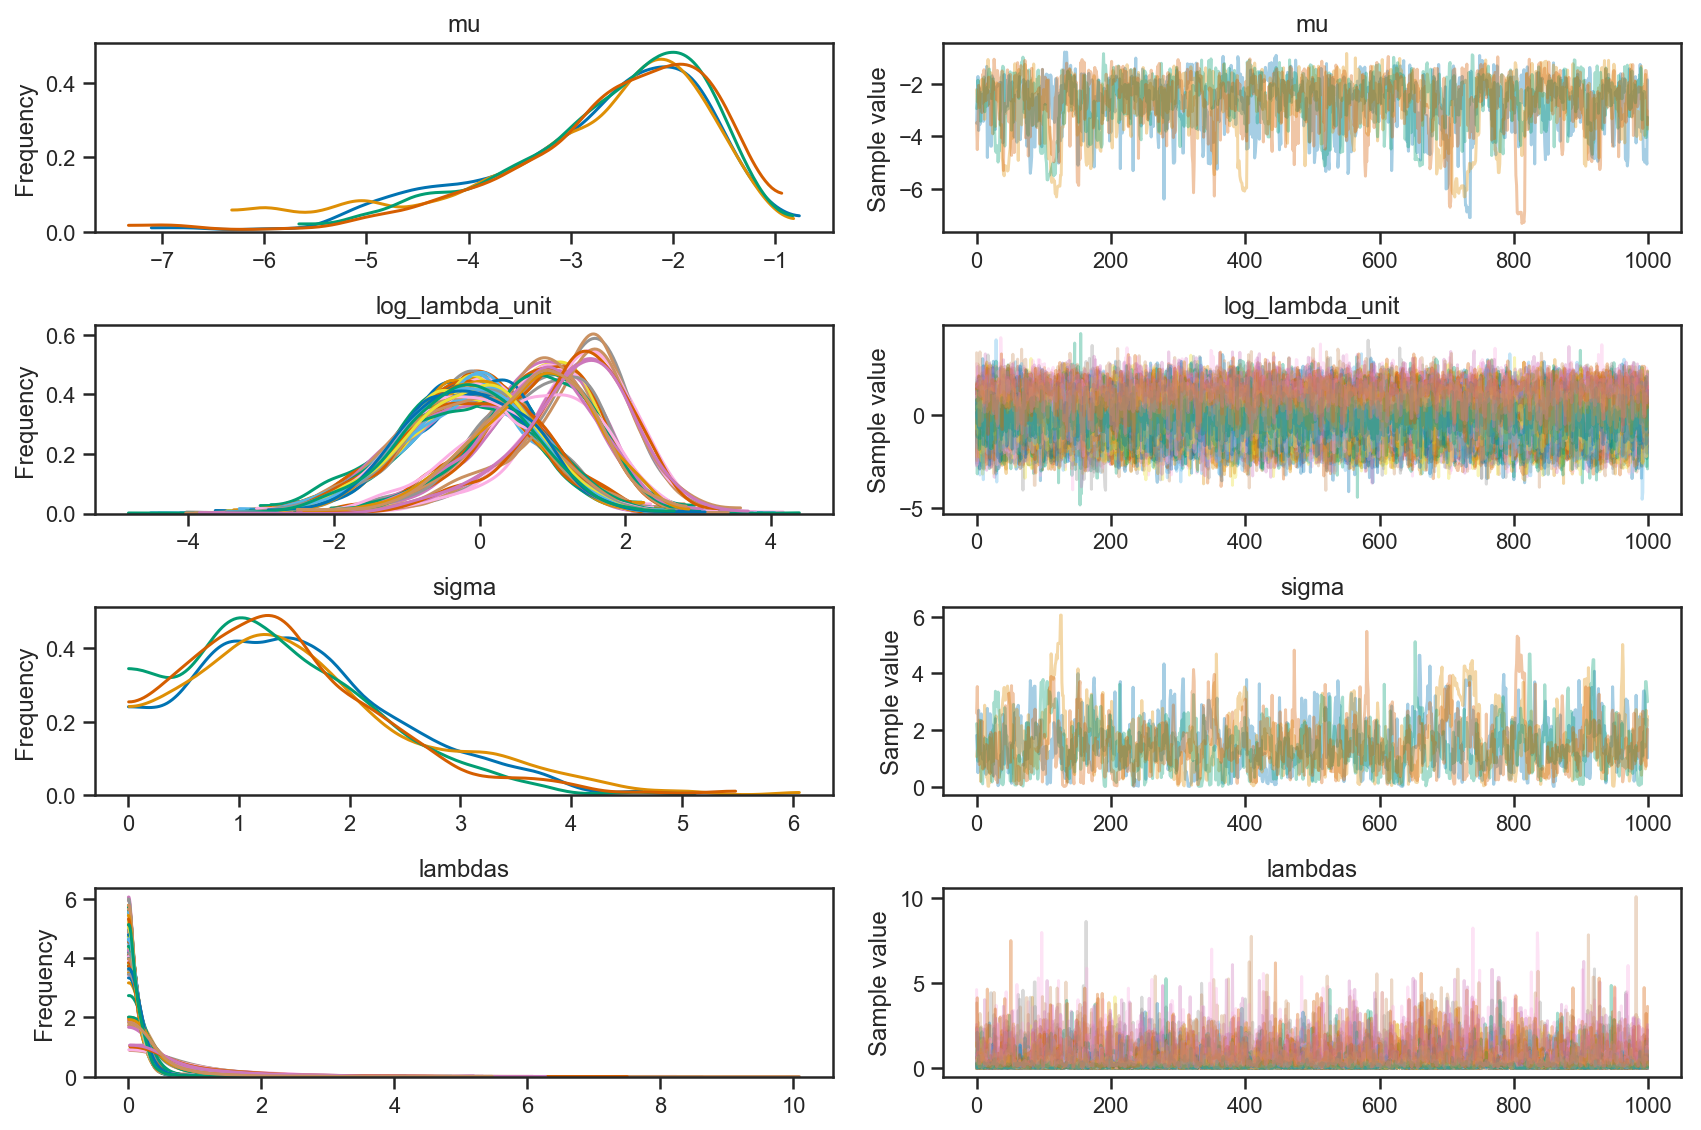

In [18]:
pm.traceplot(trace)

/Users/wfarr/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


1.4^{+0.6}_{-1.2}


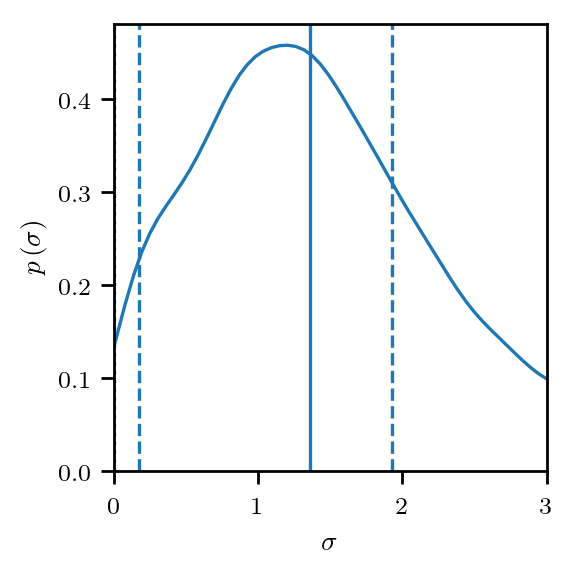

In [24]:
sns.set_context('paper')
mpl.rcParams.update(pub_rc)
try:
    sns.kdeplot(trace['sigma'])
    axis(xmin=0)
    l, h = hpd_interval(trace['sigma'], 0.68)
    ll, hh = hpd_interval(trace['sigma'], 0.95)
    m = quantile(trace['sigma'], 0.5)

    axvline(m, color=sns.color_palette()[0])
    axvline(l, color=sns.color_palette()[0], ls='--')
    axvline(h, color=sns.color_palette()[0], ls='--')
    axvline(ll, color=sns.color_palette()[0], ls=':')
    axvline(hh, color=sns.color_palette()[0], ls=':')

    xlabel(r'$\sigma$')
    ylabel(r'$p\left(\sigma\right)$')
    
    axis(xmax=3)
    
    tight_layout()
    savefig('note/sigma-2wk.pdf')
finally:
    mpl.rcdefaults()
    sns.set_context('notebook')
    
print(interval_string(trace['sigma']))

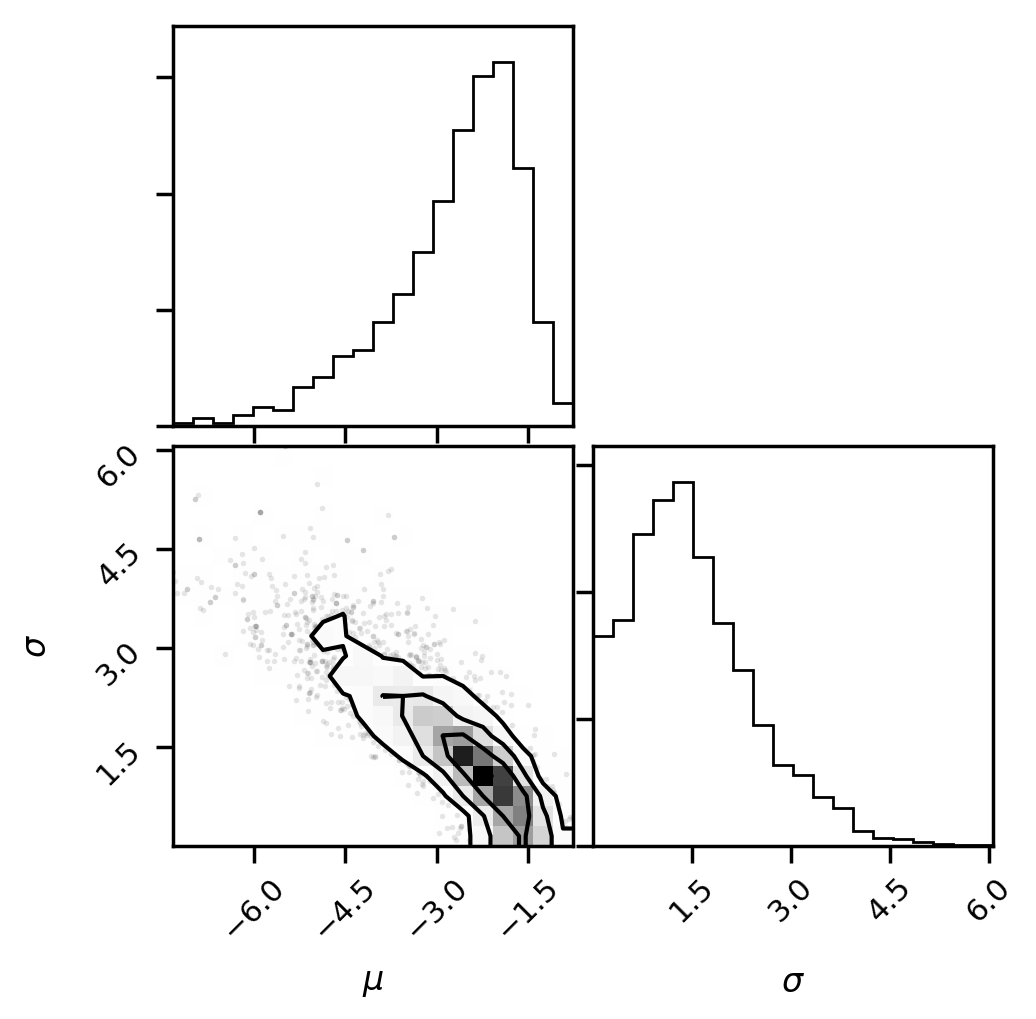

In [25]:
x = corner(column_stack([trace[n] for n in ['mu', 'sigma']]), labels=[r'$\mu$', r'$\sigma$'])